In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random, sqrt
import numpy as np
from qiskit.quantum_info import Statevector, Operator
import qiskit.quantum_info as qi

The idea is that this scheme uses code concatenation which involves 'embedding` the output of one code, the 3-qubit phase flip code in this case, into the input for another code, the 3-qubit bit flip code, so that both types of error can be accounted for by a single code.

The two logical states that will be used are the following:

In [7]:
state = QuantumRegister(9, name='|ψ_L>')

circuit = QuantumCircuit(state)

In [8]:
circuit.u(theta = random.random() * 2 * pi,
    phi = random.random() * 2 * pi,
    lam = random.random() * 2 * pi,
    qubit = state[0])
circuit.cx(state[0], state[3])
circuit.cx(state[0], state[6])

for i in range(0, 9, 3):
    circuit.h(state[i])
    circuit.cx(state[i], state[i+1])
    circuit.cx(state[i], state[i+2])

e_state = qi.Statevector.from_instruction(circuit)
e_state.draw(output="latex")

<IPython.core.display.Latex object>

In [9]:
p_I_x = 0.4
p_I_z = 0.4
def error_gate_x(qubit):
    rand_num = random.random()
    if rand_num >= p_I_x:
        circuit.x(qubit)

def error_gate_z(qubit):
    rand_num = random.random()
    if rand_num >= p_I_z:
        circuit.z(qubit)


In [10]:
choice = random.randint(0,9)
error_gate_x(state[choice])
error_gate_z(state[choice])

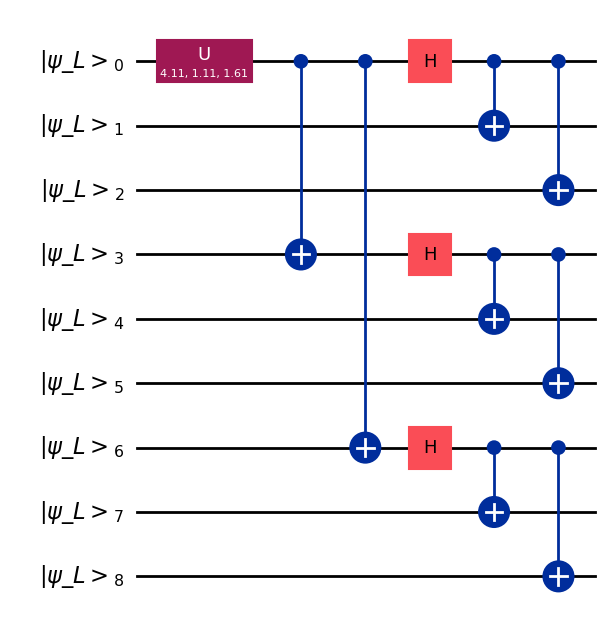

In [11]:
display(circuit.draw(output='mpl'))

In [12]:
ancillas = QuantumRegister(8, name="A")

syndrome = ClassicalRegister(8, name="S")

circuit.add_register(ancillas)
circuit.add_register(syndrome)

In [13]:

circuit.barrier()
count = 0
for i in range(0,9,3):
    for j in range(i, i+2):
        circuit.h(ancillas[count])
        circuit.cz(ancillas[count], state[j])
        circuit.cz(ancillas[count], state[j+1])
        circuit.h(ancillas[count])
        circuit.barrier()
        count += 1
    j = 0

In [14]:
for k in range(6):
    circuit.h(state[k])
    circuit.cx(k, ancillas[6])
    circuit.h(state[k])
circuit.barrier()
for l in range(3,9):
    circuit.h(state[l])
    circuit.cx(l, ancillas[7])
    circuit.h(state[l])

circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=17, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(9, '|ψ_L>'), 0), Qubit(QuantumRegister(9, '|ψ_L>'), 1), Qubit(QuantumRegister(9, '|ψ_L>'), 2), Qubit(QuantumRegister(9, '|ψ_L>'), 3), Qubit(QuantumRegister(9, '|ψ_L>'), 4), Qubit(QuantumRegister(9, '|ψ_L>'), 5), Qubit(QuantumRegister(9, '|ψ_L>'), 6), Qubit(QuantumRegister(9, '|ψ_L>'), 7), Qubit(QuantumRegister(9, '|ψ_L>'), 8), Qubit(QuantumRegister(8, 'A'), 0), Qubit(QuantumRegister(8, 'A'), 1), Qubit(QuantumRegister(8, 'A'), 2), Qubit(QuantumRegister(8, 'A'), 3), Qubit(QuantumRegister(8, 'A'), 4), Qubit(QuantumRegister(8, 'A'), 5), Qubit(QuantumRegister(8, 'A'), 6), Qubit(QuantumRegister(8, 'A'), 7)), clbits=())

In [15]:
for index, bit in enumerate(ancillas):
    circuit.measure(bit, syndrome[index])

In [16]:
#display(circuit.draw(output='mpl'))

In [17]:
result = AerSimulator().run(circuit).result()
statistics = result.get_counts()
synd = bin(0)
for k,v in statistics.items():
    print(k)
    synd = k




00000000


Error correction:

Syndrome table:
X1 10000000 Z1 00000010
X2 11000000 Z2 00000010
X3 01000000 Z3 00000010
X4 00100000 Z4 00000011
X5 00110000 Z5 00000011
X6 00010000 Z6 00000011
X7 00001000 Z7 00000001
X8 00001100 Z8 00000001
X9 00000100 Z9 00000001

In [18]:
synd_Z = synd[:2][::-1]

In [19]:
synd_X = synd[2:][::-1]

In [20]:
if synd_X == '100000':
    circuit.x(state[0])
if synd_X == '110000':
    circuit.x(state[1])
if synd_X == '001000':
    circuit.x(state[2])
if synd_X == '001100':
    circuit.x(state[3])
if synd_X == '000100':
    circuit.x(state[4])
if synd_X == '000010':
    circuit.x(state[5])
if synd_X == '000011':
    circuit.x(state[6])
if synd_X == '000001':
    circuit.x(state[7])


In [21]:
if synd_Z == '10':
    circuit.z(state[0])

if synd_Z == '11':
    circuit.z(state[3])

if synd_Z == '01':
    circuit.z(state[6])

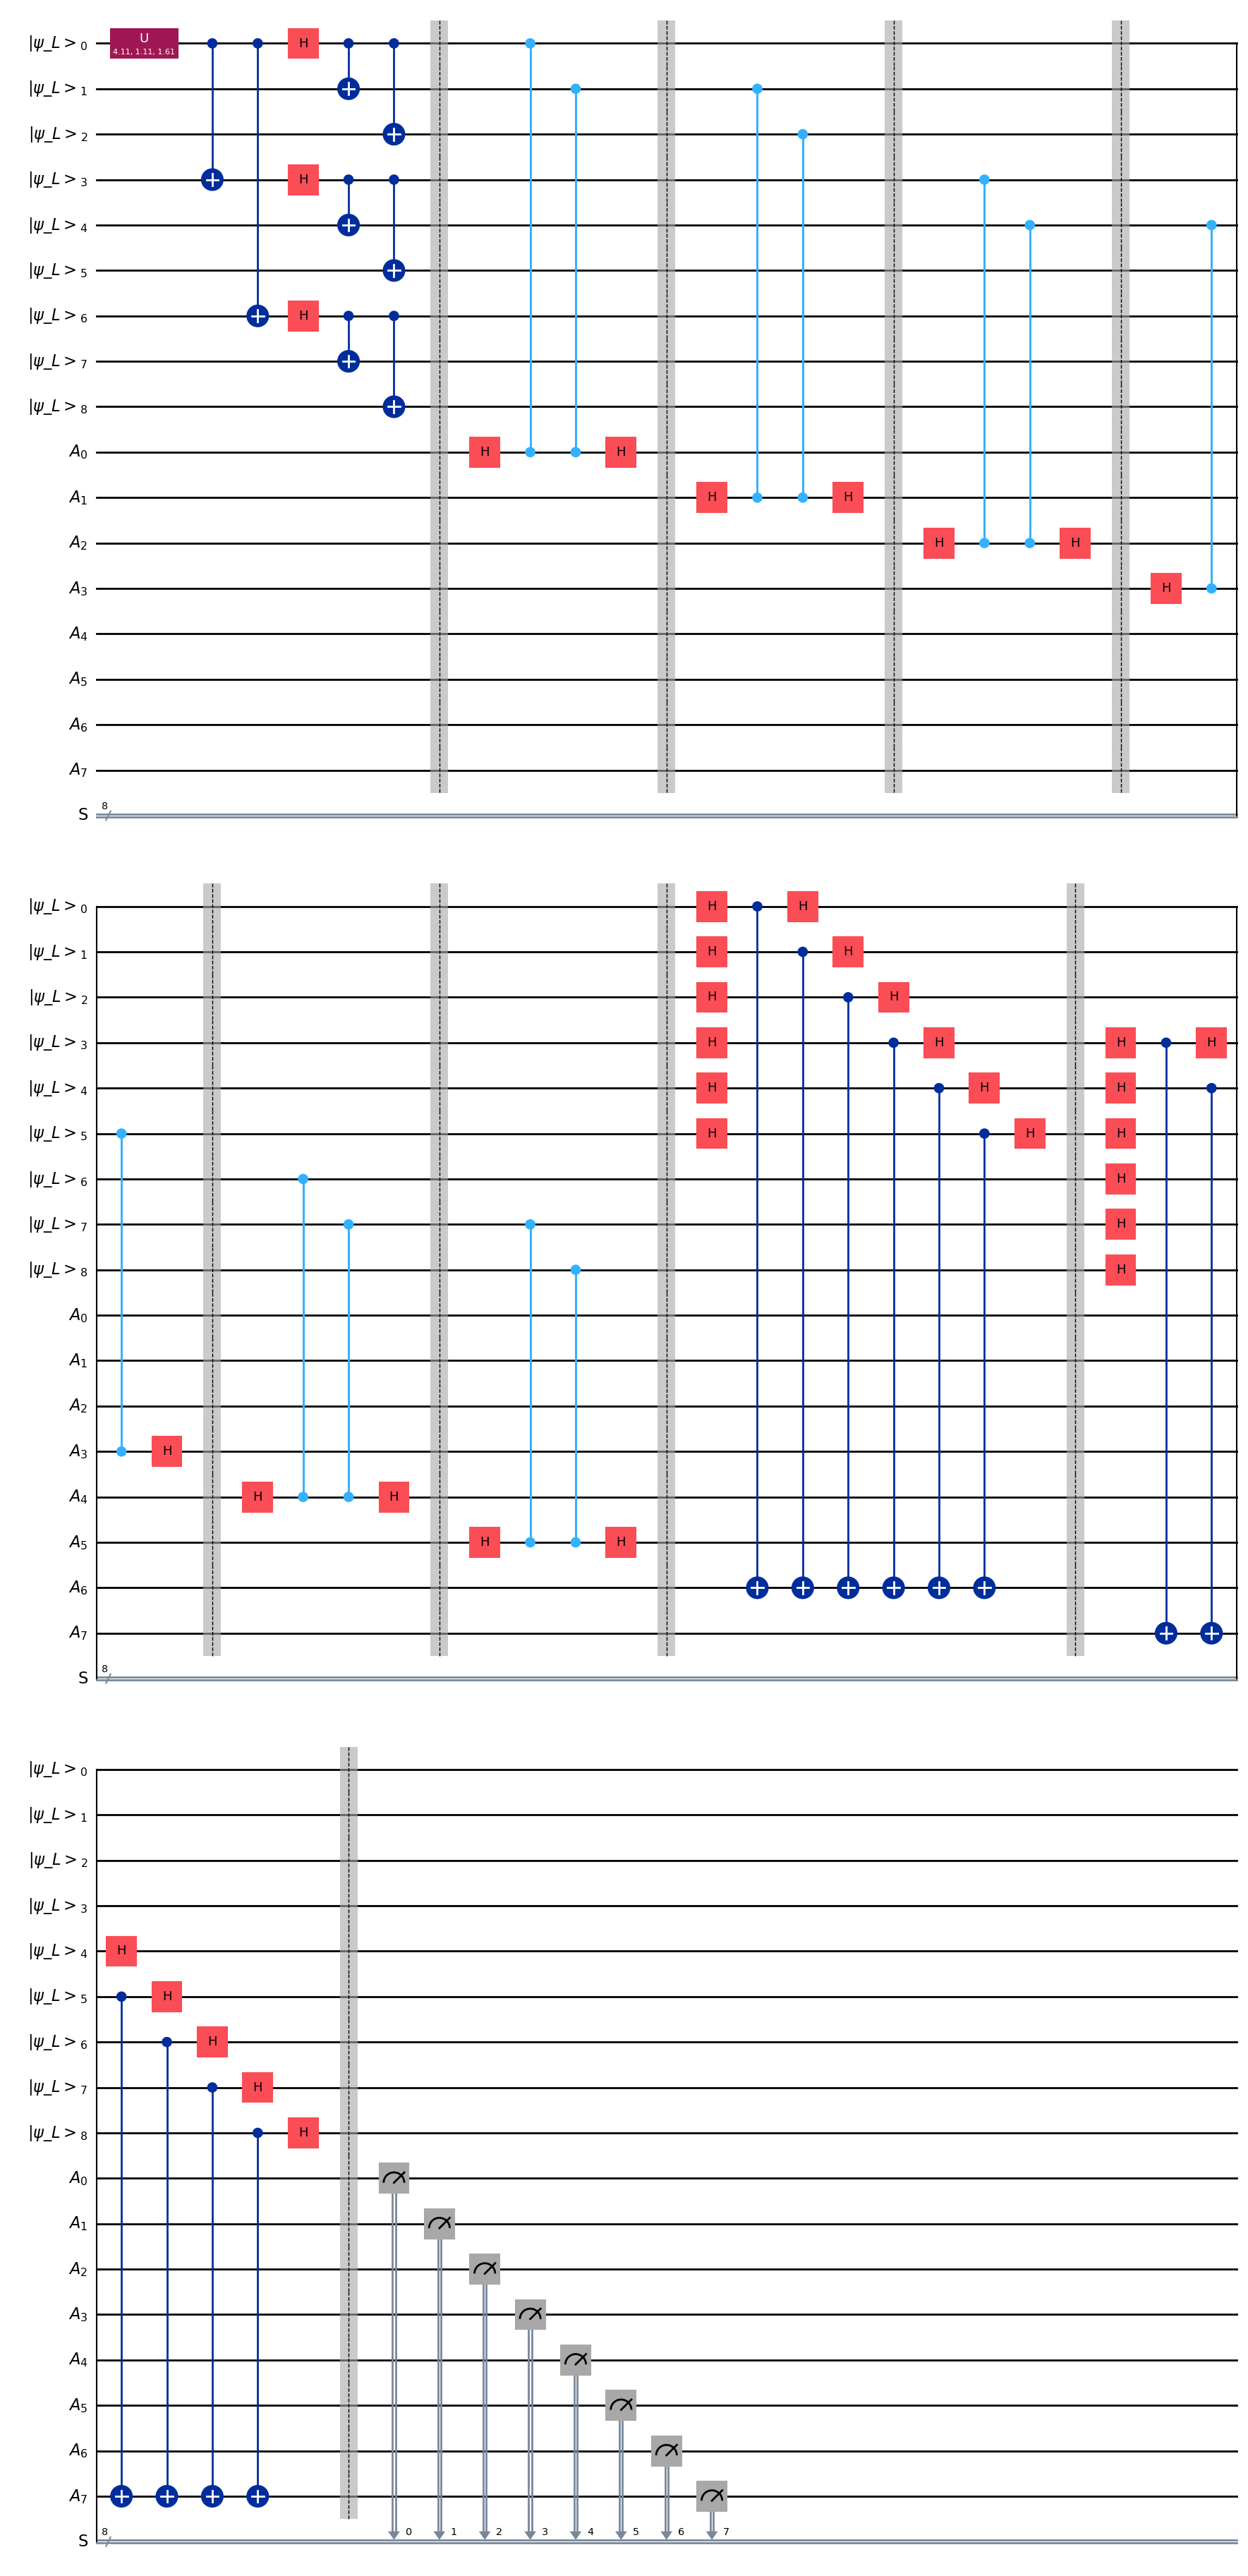

In [22]:
display(circuit.draw(output='mpl'))